## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Indlæser tekstdata og labels fra .txt-filer
# Anmeldelserne lægges i én kolonne 'review', og labels i én kolonne 'label'
df_reviews = pd.read_csv("reviews.txt", header=None, names=["review"], encoding="utf-8")
df_labels = pd.read_csv("labels.txt", header=None, names=["label"], encoding="utf-8")

# Definerer features (X) og labels (y)
X = df_reviews.review         # Tekstbaserede anmeldelser
y = df_labels.label           # 0 = negativ, 1 = positiv

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

## Neurale Netværk – Sentimentanalyse med IMDb-data

Et **neuralt netværk** er en maskinlæringsmodel inspireret af den menneskelige hjerne. Det bruges især til opgaver som **billedgenkendelse**, **sprogforståelse** og **sentimentanalyse**, hvor relationer og mønstre i komplekse data skal fanges.

### Opbygning af et neuralt netværk
Et simpelt, fuldt forbundet feedforward-netværk består af:

- **Input-lag**: modtager rå data som fx vektoriserede anmeldelser.
- **Skjulte lag**: bearbejder informationen gennem vægte og aktiveringsfunktioner. Antallet og størrelsen af disse lag bestemmer modellens kapacitet.
- **Output-lag**: leverer den endelige forudsigelse – i vores tilfælde en klassifikation som positiv (1) eller negativ (0).

### Hvordan netværket lærer
Netværket lærer gennem en proces kaldet **backpropagation**, hvor:
- Modellens forudsigelse sammenlignes med det korrekte label (fx 1 eller 0).
- Fejlen (loss) beregnes og sendes baglæns gennem netværket.
- Vægtene opdateres ved hjælp af **gradient descent** for at minimere fejl.

---

### Datasæt og forberedelse

I denne opgave bruger vi IMDb-datasættet, som indeholder **tekstbaserede filmanmeldelser (X)** og tilhørende **labels (y)**, hvor:
- **0** = negativ anmeldelse
- **1** = positiv anmeldelse

---

### Datadeling: Træning, validering og test

For at vurdere netværkets præstation korrekt, deler vi datasættet op i:

- **Træningsdata (70%)**: Bruges til at lære mønstre i data.
- **Valideringsdata (30% af resten)**: Bruges til at justere netværkets hyperparametre og undgå overfitting.
- **Testdata (20%)**: Bruges til at evaluere, hvor godt modellen klarer nye, usete data.

Denne opdeling sikrer, at modellen generaliserer og ikke bare lærer træningsdata udenad.

In [25]:
# Splitter først data i 80% midlertidig (temp) og 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitter herefter midlertidig datasæt i 70% træning og 30% validering
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=42)

# Udskriver størrelserne af de tre datasæt
print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Training: 14000, Validation: 6000, Test: 5000


### Bag-of-Words og vektorisering af tekst

For at kunne bruge tekstdata i en maskinlæringsmodel, skal ordene konverteres til tal.
Vi bruger `CountVectorizer` til at lave en **Bag-of-Words**-repræsentation, hvor:

- Hvert ord bliver en **kolonne**
- Hver anmeldelse bliver en **række** med tal
- Hvis et ord optræder 2 gange i en anmeldelse, står der 2 i den tilsvarende celle

Vi bruger kun de **10.000 mest hyppige ord** for at begrænse datamængden og undgå støj.

In [26]:
# Importér CountVectorizer til tekst-vektorisering
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser CountVectorizer og behold kun de 10.000 mest brugte ord
vectorizer = CountVectorizer(max_features=10000)

# Fit og transformer træningsdata (tilpas modellen og lav matrix)
X_train_words = vectorizer.fit_transform(X_train)

# Transformer validerings- og testdata med samme vektorstruktur
X_val_words = vectorizer.transform(X_val)
X_test_words = vectorizer.transform(X_test)

# Udskriv form på de vektoriserede datasæt (antal anmeldelser, antal features)
print("Train:", X_train_words.shape)
print("Val:", X_val_words.shape)
print("Test:", X_test_words.shape)

Train: (14000, 10000)
Val: (6000, 10000)
Test: (5000, 10000)


Vi har nu 3 datasæt i numerisk form klar til at træne et neuralt netværk:
- Hver anmeldelse er repræsenteret som en vektor med 10.000 ordfeatures.
- Værdierne i matricen angiver, hvor mange gange hvert ord forekommer i den specifikke anmeldelse.

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

## Opgave (b): Repræsentation af ord og anmeldelser

Når vi bruger `CountVectorizer`, konverteres tekstdata til tal. Hver anmeldelse bliver til en **vektor**, hvor hvert element svarer til antallet af gange et bestemt ord optræder.

Vi kan derfor:
- Hente selve ordene fra ordbogen (de første 10 fx).
- Se, hvordan én anmeldelse er repræsenteret som en vektor, og hvilke ord den indeholder.

['abandon' 'abandoned' 'abby' 'abc' 'abducted' 'abilities' 'ability'
 'able' 'aboard' 'abominable']


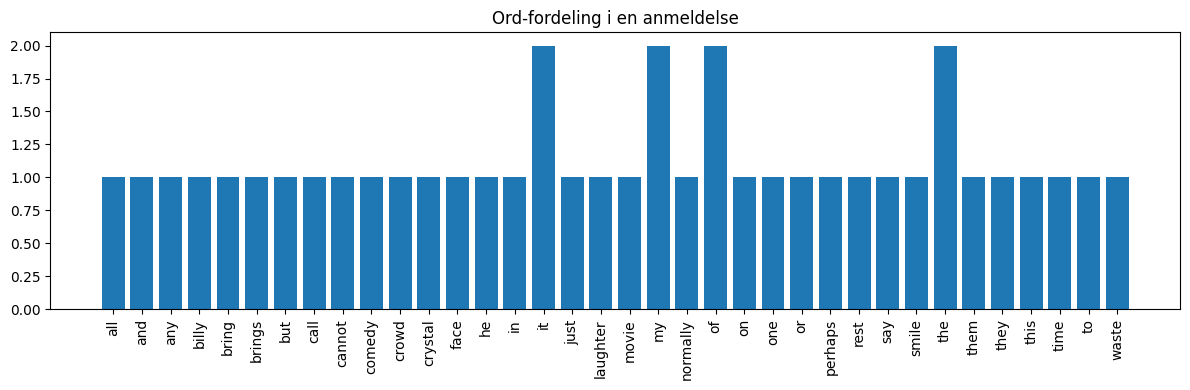

In [27]:
# Hent de 10 første ord fra ordbogen (feature-navne), som CountVectorizer har fundet
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:10])

# Vælg den første anmeldelse fra træningsdata og konverter til en tæt vektor (numpy-array)
row_vector = X_train_words[0]
dense_vector = row_vector.toarray()[0]

# Visualisér hvilke ord der optræder i anmeldelsen og hvor mange gange
plt.figure(figsize=(12, 4))

# Lav et søjlediagram hvor:
# X-aksen = ord fra anmeldelsen (kun de ord med frekvens > 0)
# Y-aksen = antal gange ordet forekommer i anmeldelsen
plt.bar(
    [feature_names[i] for i in range(len(dense_vector)) if dense_vector[i] > 0],
    [dense_vector[i] for i in range(len(dense_vector)) if dense_vector[i] > 0]
)
plt.xticks(rotation=90)
plt.title("Ord-fordeling i en anmeldelse")
plt.tight_layout()
plt.show()

### Eksempel på output
Diagrammet viser ord-fordelingen i én specifik anmeldelse fra datasættet.
- **X-akse**: De ord fra ordbogen, som forekommer i anmeldelsen.
- **Y-akse**: Hvor mange gange hvert ord forekommer.

Dette giver os en konkret forståelse af, hvordan en anmeldelse bliver til **en række tal**, som vi senere bruger som input i det neurale netværk.
> Dette er vigtigt, da neurale netværk ikke kan arbejde med tekst direkte – de har brug for numerisk input, som denne vektor repræsenterer.

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy.

### Træning af neuralt netværk med skjult lag

I denne del af opgaven trænes et simpelt **feedforward-neuralt netværk** til at forudsige, om en anmeldelse er positiv eller negativ baseret på ordforekomster (Bag-of-Words).

#### Netværksarkitektur
- **Input-lag**: 10.000 neuroner (én for hvert ord i BoW-vektoren)
- **Skjult lag**: 16 neuroner med **ReLU**-aktivering
- **Output-lag**: 1 neuron med **sigmoid**-aktivering

> **Sigmoid** returnerer en sandsynlighed mellem 0 og 1 – vi tolker > 0.5 som positiv (1), og ≤ 0.5 som negativ (0).

#### Træningsopsætning
- **Loss-funktion**: `binary_crossentropy` – bruges til binære klassifikationsopgaver
- **Optimizer**: `adam` – en effektiv metode til vægtjustering under træning
- **Batch size**: 32
- **Epochs**: 3 (lavt sat for at undgå overfitting)


Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7898 - loss: 0.4619 - val_accuracy: 0.8865 - val_loss: 0.2981
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9355 - loss: 0.1926 - val_accuracy: 0.8827 - val_loss: 0.3126
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9607 - loss: 0.1232 - val_accuracy: 0.8803 - val_loss: 0.3356


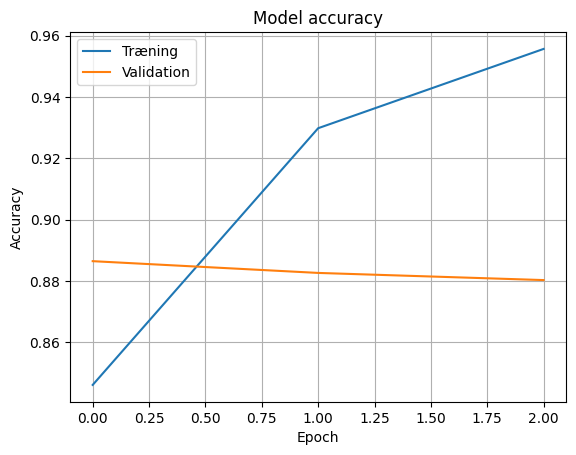

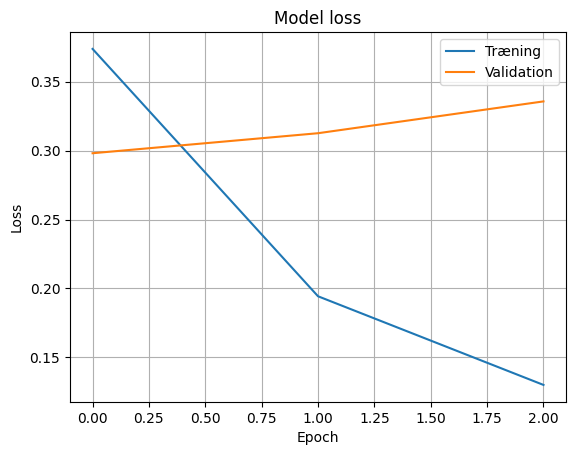

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Konverterer tekst-labels til 0 og 1 (positiv/negativ)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


# Konverter sparse matrix til dense array (TensorFlow kræver dette)
X_train_words = X_train_words.toarray()
X_val_words = X_val_words.toarray()
X_test_words = X_test_words.toarray()

# Konverterer y-værdier til float32, som kræves af TensorFlow
y_train = y_train.astype("float32")
y_val = y_val.astype("float32")
y_test = y_test.astype("float32")

# Definerer det neurale netværk:
# Inputlag → ét skjult lag med 16 neuroner og ReLU aktiveringsfunktion → outputlag med 1 neuron og sigmoid
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10000,)),                  # Input: 10.000 features (BoW)
    tf.keras.layers.Dense(16, activation='relu'),    # Skjult lag med 16 neuroner og ReLU
    tf.keras.layers.Dense(1, activation='sigmoid')   # Outputlag: 1 output med sigmoid
])

# Kompilerer modellen – vælger optimizer og loss-funktion til binær klassifikation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Træner modellen: epochs=3 for at undgå overfitting
# Valideringsdata bruges til at overvåge modelens generalisering
history = model.fit(X_train_words, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_val_words, y_val))

# Plotter accuracy-kurve: hvor godt modellen klassificerer korrekt over tid
plt.plot(history.history["accuracy"], label="Træning")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotter loss-kurve: hvor meget fejl modellen laver
plt.plot(history.history["loss"], label="Træning")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Evaluering: Accuracy og Loss

Modellen blev trænet i 3 epochs. På grafen ser vi:
- **Træningsaccuracy steg hurtigt** til over 96%
- **Valideringsaccuracy toppede omkring 87%,** hvorefter den begyndte at falde en smule
- **Træningsloss faldt stabilt**, mens **valideringsloss steg** → dette er tegn på begyndende **overfitting**

> Derfor bør man i praksis overveje teknikker som **early stopping** eller **dropout** for at undgå overtilpasning til træningsdata.

---

### Konklusion på modeltræning
- Modellen lærer hurtigt at klassificere sentiment korrekt.
- Der opnås god performance allerede efter få epochs.
- Dog ses tegn på overfitting – modellen præsterer bedre på træningsdata end på valideringsdata.

**(d)** Test your sentiment-classifier on the test set.

## Opgave d – Evaluering af sentiment-klassifikationsmodel på testdata

Efter træning og tuning evalueres modellen på det **tilbageholdte test-sæt**, som aldrig er blevet set før. Det giver et retvisende billede af modellens evne til at **generaliserer til nye anmeldelser**.

### Mål
- Forudsige sentiment (positiv/negativ) ud fra vektoriserede anmeldelser
- Evaluere præcision, recall og F1-score (fra `classification_report`)
- Visualisere fejl med en **confusion matrix**
- Måle **accuracy og loss** på testdata


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Klassifikationsrapport:

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87      2492
    Positive       0.88      0.87      0.87      2508

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



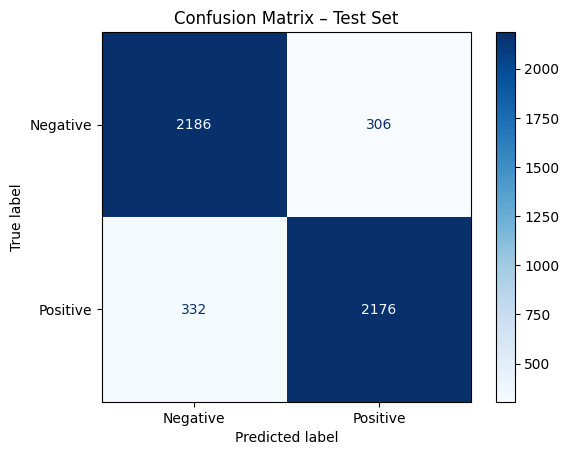

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8714 - loss: 0.3632
Test accuracy: 0.8724
Test loss: 0.3638


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Forudsige klasser (baseret på sandsynligheder)
# Model-output er sandsynligheder. Vi tolker alt over 0.5 som positiv sentiment (klasse 1)
y_pred_probs = model.predict(X_test_words)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Klassifikationsrapport: viser præcision, recall og F1-score
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Klassifikationsrapport:\n")
print(report)

# Confusion matrix: visualiserer korrekt og forkert klassificerede anmeldelser
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.grid(False)
plt.show()

# Evaluer modellen med loss og accuracy på testdata
test_loss, test_accuracy = model.evaluate(X_test_words, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


### Klassifikationsrapport

Rapporten viser:
- **Precision**: hvor mange af de forudsagte positive var faktisk positive?
- **Recall**: hvor mange af de faktiske positive blev korrekt fanget?
- **F1-score**: harmonisk gennemsnit af precision og recall

> Resultat:
> - Positiv: Precision = 0.88, Recall = 0.87 → god præcision, men nogle bliver overset.
> - Negativ: Precision = 0.87, Recall = 0.88 → Igen god præcision, men nogle bliver stadig overset

---

### Confusion Matrix

|                  | Predicted Negative | Predicted Positive |
|------------------|---------------|---------------|
| **Actual Negative** | TN (2186)     | FP (306)      |
| **Actual Positive** | FN (332)     | TP (2176)    |

- **False Positives (FP)**: negative anmeldelser klassificeres som positive.
- **False Negatives (FN)**: positive anmeldelser klassificeres som negative.
- I dette tilfælde er **false negatives det største problem** – nogle positive anmeldelser bliver fejlklassificeret som negative.

---

### Accuracy & Loss

- **Test accuracy**: fx 0.8724 → modellen præsterer godt på ukendte data
- **Test loss**: fx 0.3638 → acceptabel fejlrate, men kunne være lavere

---

### Tolkning

- Modellen har **høj præcision på positiv sentiment**, men **mangler lidt i recall**, hvilket betyder at den **overser nogle positive anmeldelser**.
- På negativ sentiment klarer den sig bedre → **balanceret performance**.
- Let bias mod at klassificere "negativt", hvilket er normalt i sentiment-analyse (man er hellere for forsigtig end for positiv).

---

### Konklusion

Den trænede sentiment-klassifikationsmodel:
- Har **stabil performance** med accuracy omkring 87 %
- Klarer sig godt på **negativ sentiment**
- Overser enkelte positive anmeldelser, men med **god præcision**
- Confusion matrix viser **få fejl og god balance**
- **Anbefaling**: Hvis recall på positive skal forbedres, bør man evt. **justere sandsynlighedstærskel** (fra 0.5 → 0.4) eller arbejde med **class weights** eller **data balance**

**(e)** Use the classifier to classify a few sentences you write yourselves.

## Opgave (e): Brug modellen på egne sætninger

I denne opgave bruger vi den **trænede sentiment-klassifikationsmodel** til at forudsige stemningen i brugerdefinerede sætninger.
Vi anvender den samme **Bag-of-Words-vektoriseringsmodel** som i træningsfasen til at konvertere sætningerne til tal.

Modellen returnerer en **sandsynlighed mellem 0 og 1**, hvor vi tolker:
- Sandsynlighed > 0.5 → **positiv anmeldelse**
- Sandsynlighed ≤ 0.5 → **negativ anmeldelse**

In [30]:
# Liste med egne sætninger til test
custom_sentences = [
    "Excellent plot and great characters! Loved the movie",
    "The best movie I have seen in a while, I never want to watch it again",
    "The absolute greatest waste of time ever.",
    "Horrible movie and terrible acting",
    "Absolutely loved how the plot made no sense and the characters were completely unbelievable.",
    "Taken 3 makes Taken 2 look like Taken 1",
    "Megalopolis is an Ambitious Art Film So Bad It Made Me Hate Ambition, Art and Film"
]

# Vektoriserer sætningerne med samme CountVectorizer som i træning
custom_bow = vectorizer.transform(custom_sentences).toarray()

# Bruger den trænede model til at forudsige sandsynlighed for positivt sentiment
pred_probs = model.predict(custom_bow).flatten()

# Udskriver sætning + label og sandsynlighed
for sentence, prob in zip(custom_sentences, pred_probs):
    label = "Positive" if prob > 0.5 else "Negative"
    print(f"{label} ({prob:.2f}) → {sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Positive (0.78) → Excellent plot and great characters! Loved the movie
Positive (0.69) → The best movie I have seen in a while, I never want to watch it again
Negative (0.25) → The absolute greatest waste of time ever.
Negative (0.17) → Horrible movie and terrible acting
Negative (0.24) → Absolutely loved how the plot made no sense and the characters were completely unbelievable.
Positive (0.53) → Taken 3 makes Taken 2 look like Taken 1
Negative (0.43) → Megalopolis is an Ambitious Art Film So Bad It Made Me Hate Ambition, Art and Film


### Analyse
Modellen klassificerer de fleste sætninger korrekt, Fx:
- “Horrible movie and terrible acting” → negativ
- “Excellent plot and great characters” → positiv

Den fanger også sarkasme og komplekse sætninger:
- Fx: “Absolutely loved how the plot made no sense...” → starter positivt men klassificeres korrekt som negativ
Det indikerer, at modellen har lært mere end bare ord-for-ord sentiment, men forstår kontekst og kombinationer.

### Konklusion
Modellen kan bruges på nye tekster, og klarer sig godt – også når sætninger indeholder ironi eller blandede signaler.
Det viser, at den har lært meningsfulde mønstre i stedet for blot at reagere på enkelte ord.

Sentimentanalysen fungerer som forventet – og modellen er robust nok til at fortolke virkelige sætninger!